In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from scipy import stats
from helper import *
from scipy.stats.mstats import gmean
#Importation of all the packages
from datetime import datetime
import math
import json
import zipfile  
import ssl
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn import metrics

#To dowload data
import requests
import io
import gzip

#To create the mapchart
import iso3166
import plotly
from iso3166 import countries
import plotly.graph_objects as go


from collections import defaultdict

/Users/arthurnussbaumer/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
country_dict = get_country_dict('original')
inv_country_dict = {v: k for k, v in country_dict.items()}

In [3]:
# Dowload Trust dataset
data_folder = 'data_2/'
df_trust_gov = pd.read_csv(data_folder+'share-who-trust-government.csv.zip') 
df_trust_science = pd.read_csv(data_folder+'share-people-trust-science.csv.zip')
df_trust_journalists = pd.read_csv(data_folder+'share-people-trust-journalists-country.csv.zip')

In [4]:
COUNTRY_OWN_LANG_TRUST_JOURN = {"Italy" : "it", "Russia": "ru", "China": "zh", "Albania": "sq", 
"Bangladesh": "bn", "Cambodia": "km", "Croatia": "hr", "Greece": "el", "Sweden": "sv", "Finland": "fi", "Norway": "no",
 "Malaysia": "ms", "Israel": "he", "Lithuania": "lt", "Serbia": "sr", "Slovakia": "sk", "Slovenia": "sl", "Turkey": "tr",
 "Vietnam": "vi", "Bulgaria": "bg", "Czechia": "cs", "Denmark": "da", "Georgia": "ka", "Germany": "de", 
 "Hungary": "hu", "Japan": "ja", "Kazakhstan": "kk", "South Korea": "ko", "Kyrgyzstan": 'ky', "Netherlands": "nl", "Poland": "pl", 
 "Romania": "ro", "Tajikistan": "tg", "Thailand": "th", "Mongolia": "mn"}

COUNTRY_OWN_LANG_TRUST_GOV = {"Italy" : "it", "Russia": "ru", "Albania": "sq", 
"Bangladesh": "bn", "Cambodia": "km", "Croatia": "hr", "Greece": "el", "Sweden": "sv", "Finland": "fi", "Norway": "no",
 "Malaysia": "ms", "Israel": "he", "Lithuania": "lt", "Serbia": "sr", "Slovakia": "sk", "Slovenia": "sl", "Turkey": "tr", "Bulgaria": "bg", "Czechia": "cs", "Denmark": "da", "Georgia": "ka", "Germany": "de", 
 "Hungary": "hu", "Japan": "ja", "Kazakhstan": "kk", "South Korea": "ko", "Kyrgyzstan": 'ky', "Netherlands": "nl", "Poland": "pl", 
 "Romania": "ro", "Thailand": "th", "Mongolia": "mn"}

COUNTRY_OWN_LANG_SCIENCE = {"Italy" : "it", "Russia": "ru", "China": "zh", "Albania": "sq", 
"Bangladesh": "bn", "Cambodia": "km", "Croatia": "hr", "Greece": "el", "Sweden": "sv", "Finland": "fi", "Norway": "no",
 "Malaysia": "ms", "Israel": "he", "Lithuania": "lt", "Serbia": "sr", "Slovakia": "sk", "Slovenia": "sl", "Turkey": "tr",
 "Vietnam": "vi", "Bulgaria": "bg", "Czechia": "cs", "Denmark": "da", "Georgia": "ka", "Germany": "de", 
 "Hungary": "hu", "Japan": "ja", "Kazakhstan": "kk", "South Korea": "ko", "Kyrgyzstan": 'ky', "Netherlands": "nl", "Poland": "pl", 
 "Romania": "ro", "Tajikistan": "tg", "Thailand": "th", "Mongolia": "mn"}


df_trust_journalists = df_trust_journalists.set_index("Entity")[["Trust journalists in this country"]].transpose()[COUNTRY_OWN_LANG_TRUST_JOURN.keys()].rename(columns= COUNTRY_OWN_LANG_TRUST_JOURN)
df_trust_gov = df_trust_gov.set_index("Entity")[["Trust the national government in this country"]].transpose()[COUNTRY_OWN_LANG_TRUST_GOV.keys()].rename(columns= COUNTRY_OWN_LANG_TRUST_GOV)
df_trust_science = df_trust_science.set_index("Entity")[["Trust science"]].transpose()[COUNTRY_OWN_LANG_SCIENCE.keys()].rename(columns= COUNTRY_OWN_LANG_SCIENCE)

In [5]:
print(len(COUNTRY_OWN_LANG_TRUST_JOURN))
print(len(COUNTRY_OWN_LANG_TRUST_GOV))
print(len(COUNTRY_OWN_LANG_SCIENCE))

35
32
35


In [6]:
ssl._create_default_https_context = ssl._create_unverified_context
death_url = "https://github.com/owid/covid-19-data/blob/master/public/data/jhu/new_deaths.csv?raw=true" # Make sure the url is the raw version of the file on GitHub
cases_url = "https://github.com/owid/covid-19-data/blob/master/public/data/jhu/new_cases.csv?raw=true"

# Reading the downloaded content and turning it into a pandas dataframe
deaths = pd.read_csv(death_url,index_col=0)
cases = pd.read_csv(cases_url,index_col=0)
deaths= deaths.interpolate(method ='linear', limit_direction ='forward') 
cases = cases.interpolate(method ='linear', limit_direction ='forward') 
deaths = deaths.fillna(0)
cases = cases.fillna(0)
#Keep only values until July
deaths = deaths[deaths.index < '2021-01-01']
cases = cases[cases.index < '2021-01-01']

In [7]:
# Divide trust interval into nbr_category and label the countries
def trust_category(trust, nbr_category, country_dict):
    min_trust = float(trust.min(axis=1))
    max_trust = trust.max(axis=1)
    
    delta = float((max_trust-min_trust))/nbr_category
    
    for j in list(country_dict.keys()):
        country_trust = float(trust[country_dict[j]])
        for i in range(nbr_category):
            if (country_trust >= min_trust + i*delta) & (country_trust < min_trust + (i+1)*delta):
                country_dict[j] = [country_dict[j], i]
            elif (country_trust == (min_trust + (i+1)*delta)) & (i == (nbr_category-1)):
                country_dict[j] = [country_dict[j], i]
            

In [8]:
population_df = pd.read_csv("Population_countries.csv")
population_df = population_df[["Country Name", "2020"]]
population_df = population_df.set_index("Country Name")
population_df = population_df.rename({"Russian Federation": "Russia", "Slovak Republic": "Slovakia", "Turkiye": "Turkey","Korea, Rep.": "South Korea", "Kyrgyz Republic": 'Kyrgyzstan'})

In [9]:
# Creating the stacked plot
def stack_graph(trust, country_dict):
    #Divide into categories the countries
    trust_category(trust, 5, country_dict)
    
    trust_cat = {k: v[1] for k, v in country_dict.items()}
    trust_country = defaultdict(list)
    
    for key, val in sorted(trust_cat.items()):
        trust_country[val].append(key)

    #Create death per 100'000 people dataframe per trust category
    death = pd.DataFrame({})
    for i in range(5):
        death[i] = deaths[trust_country[i]].sum(axis = 1)/float(population_df.loc[trust_country[i]].sum()) * 100000
    
    death = death.fillna(0)
    
    death.set_index(deaths.index)
    # Plot x-labels, y-label and data
    plt.figure(figsize=(15, 5))
    plt.plot([], [], color ='blue',
             label ='Cat 1')
    plt.plot([], [], color ='orange',
             label ='Cat 2')
    plt.plot([], [], color ='brown',
             label ='Cat 3')
    plt.plot([], [], color ='red',
             label ='Cat 4')
    plt.plot([], [], color ='green',
             label ='Cat 5')
    
    # Implementing stackplot on data
    plt.stackplot(death.index, death[0], death[1], death[2], death[3], death[4],
                  baseline ='zero',
                  colors =['blue', 'orange',
                           'brown', 'red', 'green'])

    plt.legend(loc = 'upper left')
    plt.xticks(deaths.index[::30])
    plt.title('Number of deaths per 100000')
    plt.xlabel('Date')
    plt.ylabel('Overall deaths per 100000')

    plt.show()

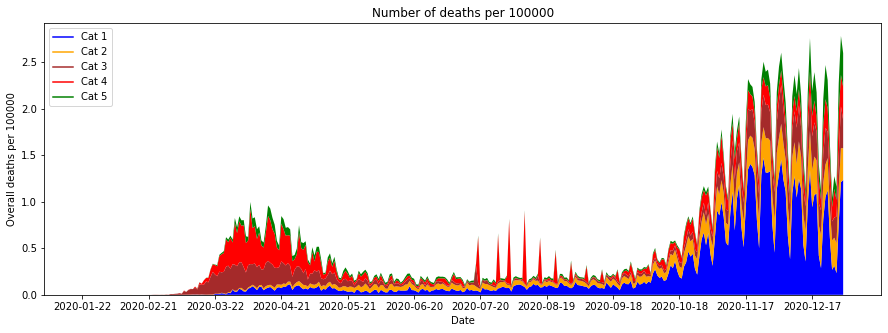

In [10]:
stack_graph(df_trust_gov, COUNTRY_OWN_LANG_TRUST_GOV)

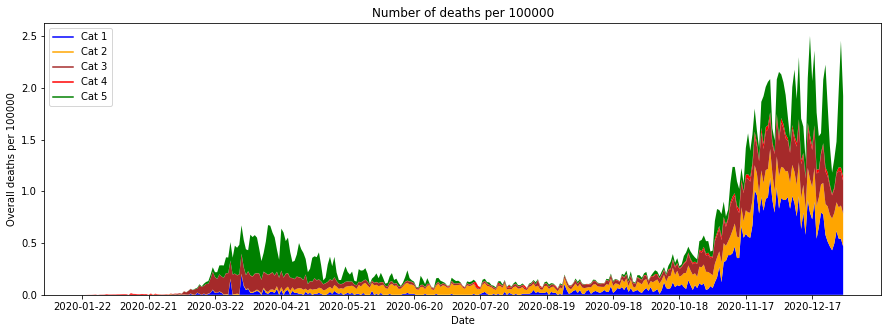

In [11]:
stack_graph(df_trust_journalists, COUNTRY_OWN_LANG_TRUST_JOURN)

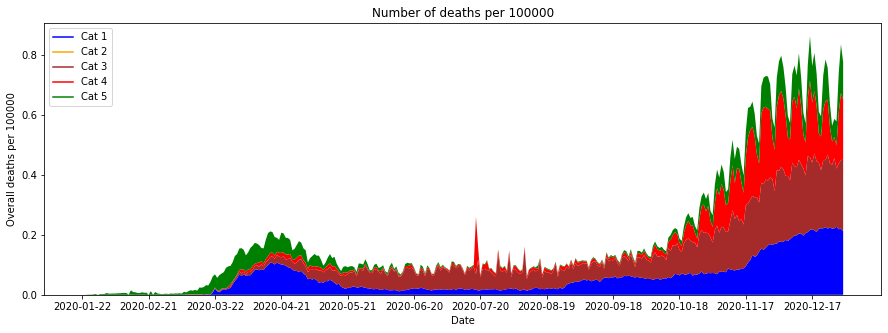

In [12]:
stack_graph(df_trust_science, COUNTRY_OWN_LANG_SCIENCE)